# Tugas FP ML

Link Dataset : https://www.kaggle.com/datasets/ekojsalim/indonesia-college-entrance-examination-utbk-2019

Link Notebook : https://www.kaggle.com/code/kevinnathanaelhalim/classifier-model-analysis-for-utbk-2019-ub-science/notebook

In [1]:
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_univ = pd.read_csv('/kaggle/input/indonesia-college-entrance-examination-utbk-2019/universities.csv')
df_major = pd.read_csv('/kaggle/input/indonesia-college-entrance-examination-utbk-2019/majors.csv')
df_score = pd.read_csv('/kaggle/input/indonesia-college-entrance-examination-utbk-2019/score_science.csv')

# Initial Data Visualization

## Universities

In [4]:
# df_univ

profile_univ = ProfileReport(df_univ,title="Universities Data Report")
profile_univ.to_file("report_univ.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# profile_univ

## Majors

In [6]:
# df_major

profile_major = ProfileReport(df_major,title="Majors Data Report")
profile_major.to_file("report_major.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# profile_major

## Scores

In [8]:
# df_score

profile_score = ProfileReport(df_score,title="Scores Data Report")
profile_score.to_file("report_score.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# profile_score

# Data Cleaning

In [10]:
id_ub = df_univ[df_univ.university_name == "UNIVERSITAS BRAWIJAYA"]["id_university"].values[0]
print("ID UB => ", id_ub)

ID UB =>  372


In [11]:
df_score.drop(columns=['Unnamed: 0'], inplace = True)
# df_score = df_score[(df_score.id_first_university == id_its) | (df_score.id_second_university == id_its)]
df_score['average_score'] = df_score.iloc[:, 5:].mean(axis = 1)
df_score.sort_values('average_score', ascending = False, inplace = True)
df_score.reset_index(drop = True, inplace = True)
df_score

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,score_bio,score_fis,score_kim,score_kmb,score_kpu,score_kua,score_mat,score_ppu,average_score
0,7111196,711,3331156,333,315473,867,954,913,843,837,922,967,781,885.500
1,3211216,321,7121167,712,186376,952,918,889,844,793,911,957,772,879.500
2,3211077,321,3331164,333,155969,800,950,863,866,870,805,952,795,862.625
3,3321073,332,3211015,321,172857,687,1052,752,793,856,887,988,824,854.875
4,3321096,332,3321107,332,312199,850,880,792,893,865,812,895,827,851.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86565,8111246,811,7111424,711,215734,369,295,472,286,304,467,412,324,366.125
86566,5511096,551,5511096,551,315984,322,410,436,385,332,428,356,253,365.250
86567,7131154,713,7411041,741,315289,310,403,345,475,368,297,285,373,357.000
86568,1611043,161,1611155,161,280369,287,464,333,276,322,322,294,467,345.625


In [12]:
df_major[df_major.id_university == id_ub]

,Unnamed: 0,id_major,id_university,type,major_name,capacity
907,907,3721015,372,science,MANAJEMEN SUMBERDAYA PERAIRAN,72
908,908,3721023,372,science,BUDIDAYA PERAIRAN,72
909,909,3721031,372,science,TEKNIK SIPIL,70
910,910,3721046,372,science,TEKNIK MESIN,80
911,911,3721054,372,science,TEKNIK ELEKTRO,80
...,...,...,...,...,...,...
2537,2537,3722324,372,humanities,ADMINISTRASI PENDIDIKAN,32
2538,2538,3722332,372,humanities,SENI RUPA MURNI,24
2539,2539,3722347,372,humanities,SASTRA CINA,32
2540,2540,3722355,372,humanities,ANTROPOLOGI SOSIAL,28


In [13]:
df_major.drop(columns = ['Unnamed: 0'], inplace = True)

In [14]:
df = pd.merge(df_score, df_major[['major_name', 'capacity']], left_on='id_first_major', 
                       right_on=df_major.id_major, how='left')
df = pd.merge(df, df_major[['major_name', 'capacity']], left_on='id_second_major', 
                       right_on=df_major.id_major, how='left', suffixes=('_1', '_2'))

In [15]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [16]:
df['status'] = np.nan
df['accepted_applicants_1'] = 0
df['accepted_applicants_2'] = 0

In [17]:
df

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,score_bio,score_fis,score_kim,score_kmb,score_kpu,...,score_mat,score_ppu,average_score,major_name_1,capacity_1,major_name_2,capacity_2,status,accepted_applicants_1,accepted_applicants_2
0,7111196,711,3331156,333,315473,867,954,913,843,837,...,967,781,885.500,PENDIDIKAN DOKTER GIGI,50.0,TEKNIK PERTANIAN,50.0,NaN,0,0
1,3211216,321,7121167,712,186376,952,918,889,844,793,...,957,772,879.500,TEKNIK KOMPUTER,32.0,PENDIDIKAN TEKNIK INFORMATIKA & KOMPUTER,44.0,NaN,0,0
2,3211077,321,3331164,333,155969,800,950,863,866,870,...,952,795,862.625,FARMASI,52.0,FARMASI,80.0,NaN,0,0
3,3321073,332,3211015,321,172857,687,1052,752,793,856,...,988,824,854.875,SEKOLAH TEK. ELEKTRO & INFORMATIKA (STEI),238.0,PENDIDIKAN DOKTER,72.0,NaN,0,0
4,3321096,332,3321107,332,312199,850,880,792,893,865,...,895,827,851.750,FAKULTAS TEKNIK MESIN & DIRGANTARA (FTMD),120.0,"SEK. ARSITEKTUR, PERENC & PENGEMB KEBIJAKAN",68.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86564,8111246,811,7111424,711,215734,369,295,472,286,304,...,412,324,366.125,PENDIDIKAN DOKTER,75.0,PSIKOLOGI,35.0,NaN,0,0
86565,5511096,551,5511096,551,315984,322,410,436,385,332,...,356,253,365.250,MANAJEMEN SUMBER DAYA PERAIRAN,48.0,MANAJEMEN SUMBER DAYA PERAIRAN,48.0,NaN,0,0
86566,7131154,713,7411041,741,315289,310,403,345,475,368,...,285,373,357.000,SISTEM INFORMASI,20.0,TEKNIK SIPIL,143.0,NaN,0,0
86567,1611043,161,1611155,161,280369,287,464,333,276,322,...,294,467,345.625,AGRIBISNIS,50.0,TEKNIK SIPIL,50.0,NaN,0,0


In [18]:
for applicant in df.index:
#     print("Iterasi ke -> ", applicant)
    first_major = df.loc[applicant, 'id_first_major']
    second_major = df.loc[applicant, 'id_second_major']    
    first_major_capacity = df[df.id_first_major == first_major]["capacity_1"].values[0]
    second_major_capacity = df[df.id_second_major == second_major]["capacity_2"].values[0]
    first_major_accepted = df[df.id_first_major == first_major]["accepted_applicants_1"].values[0]
    second_major_accepted = df[df.id_second_major == second_major]["accepted_applicants_2"].values[0]
    if first_major_accepted < first_major_capacity:
        df.loc[df.id_first_major == first_major, "accepted_applicants_1"] += 1
        df.loc[applicant, 'status'] = "Accepted First Choice"
    elif second_major_accepted < second_major_capacity:
        df.loc[df.id_second_major == second_major, "accepted_applicants_2"] += 1
        df.loc[applicant, 'status'] = "Accepted Second Choice"
    else:
        df.loc[applicant, 'status'] = "Failed"

In [19]:
df.status.unique()

array(['Accepted First Choice', 'Accepted Second Choice', 'Failed'],
      dtype=object)

In [20]:
# df

profile_df = ProfileReport(df,title="Scores All Universities Data Report")
profile_df.to_file("report_df.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# profile_df

In [22]:
df.to_csv("UTBK_2019_ALL.csv")

## Score UB

In [23]:
df_ub_1 = df[df.id_first_university == 372]
df_ub_2 = df[df.id_second_university == 372]

In [24]:
df_ub_1

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,score_bio,score_fis,score_kim,score_kmb,score_kpu,...,score_mat,score_ppu,average_score,major_name_1,capacity_1,major_name_2,capacity_2,status,accepted_applicants_1,accepted_applicants_2
56,3721127,372,3561111,356,245568,786,822,994,596,724,...,639,665,763.750,KIMIA,80.0,KIMIA,32.0,Accepted First Choice,80,32
242,3721085,372,6111014,611,83381,764,887,758,621,624,...,832,559,733.750,PENDIDIKAN DOKTER,100.0,PENDIDIKAN DOKTER,125.0,Accepted First Choice,100,125
277,3721255,372,3711206,371,149791,820,607,595,725,783,...,777,687,730.500,TEKNIK INFORMATIKA,96.0,SISTEM INFORMASI,75.0,Accepted First Choice,96,31
305,3721255,372,3811157,381,320934,777,758,742,719,723,...,717,689,728.375,TEKNIK INFORMATIKA,96.0,SISTEM INFORMASI,32.0,Accepted First Choice,96,32
416,3721085,372,1111022,111,305806,694,567,736,688,720,...,915,666,721.000,PENDIDIKAN DOKTER,100.0,TEKNIK SIPIL,64.0,Accepted First Choice,100,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86436,3721031,372,1911046,191,47466,378,445,420,334,374,...,381,330,402.875,TEKNIK SIPIL,70.0,TEKNIK SIPIL,66.0,Accepted Second Choice,70,27
86447,3721031,372,3551171,355,318711,399,330,567,482,369,...,286,370,402.250,TEKNIK SIPIL,70.0,TEKNIK SIPIL,80.0,Failed,70,80
86464,3721166,372,3621416,362,196136,445,431,407,357,387,...,505,389,400.500,AGROBISNIS PERIKANAN,72.0,PENDIDIKAN KEPELATIHAN OLAHRAGA,48.0,Accepted Second Choice,72,10
86503,3721054,372,3411265,341,195965,403,470,440,324,385,...,384,351,393.875,TEKNIK ELEKTRO,80.0,TEKNOLOGI INDUSTRI PERTANIAN,63.0,Accepted Second Choice,80,39


In [25]:
df_ub_2

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,score_bio,score_fis,score_kim,score_kmb,score_kpu,...,score_mat,score_ppu,average_score,major_name_1,capacity_1,major_name_2,capacity_2,status,accepted_applicants_1,accepted_applicants_2
49,3211015,321,3721085,372,176266,745,727,857,714,720,...,778,740,764.625,PENDIDIKAN DOKTER,72.0,PENDIDIKAN DOKTER,100.0,Accepted First Choice,72,100
102,3611066,361,3721085,372,259970,1000,699,825,735,778,...,740,638,752.375,KEDOKTERAN,79.0,PENDIDIKAN DOKTER,100.0,Accepted First Choice,79,100
112,3611066,361,3721085,372,321833,789,699,740,793,751,...,754,784,750.875,KEDOKTERAN,79.0,PENDIDIKAN DOKTER,100.0,Accepted First Choice,79,100
125,3321081,332,3721085,372,154819,596,844,823,589,710,...,771,739,747.625,FAKULTAS TEKNOLOGI INDUSTRI (FTI) - KAMPUS GANESA,144.0,PENDIDIKAN DOKTER,100.0,Accepted First Choice,144,100
162,3811014,381,3721085,372,217772,962,604,817,696,723,...,567,764,741.750,PENDIDIKAN DOKTER,100.0,PENDIDIKAN DOKTER,100.0,Accepted First Choice,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86425,6211224,621,3721321,372,206330,432,450,455,384,377,...,338,406,403.750,PENDIDIKAN DOKTER,50.0,KEBIDANAN,44.0,Failed,50,44
86434,3571105,357,3721023,372,309406,385,294,377,359,440,...,362,530,402.875,TEKNOLOGI INFORMASI,24.0,BUDIDAYA PERAIRAN,72.0,Accepted Second Choice,24,19
86437,3551325,355,3721263,372,26794,449,323,340,347,433,...,413,406,402.875,AGRIBISNIS,50.0,AGROEKOTEKNOLOGI,312.0,Accepted Second Choice,50,101
86453,3551236,355,3721367,372,91940,420,464,354,367,356,...,461,436,402.000,TEKNIK INDUSTRI,75.0,SISTEM INFORMASI,64.0,Failed,75,64


In [26]:
df_ub_1 = df_ub_1.replace(['Accepted First Choice', 'Failed'],
                            ['1', '0'])
df_ub_1.status.unique()

array(['1', 'Accepted Second Choice', '0'], dtype=object)

In [27]:
df_ub_1 = df_ub_1[df_ub_1['status'] != 'Accepted Second Choice']
df_ub_1.status.unique()

array(['1', '0'], dtype=object)

In [28]:
df_ub_2 = df_ub_2.replace(['Accepted Second Choice', 'Failed'],
                            ['2', '0'])
df_ub_2.status.unique()

array(['Accepted First Choice', '2', '0'], dtype=object)

In [29]:
df_ub_2 = df_ub_2[df_ub_2['status'] != 'Accepted First Choice']
df_ub_2.status.unique()

array(['2', '0'], dtype=object)

In [30]:
df_ub = pd.concat([df_ub_1, df_ub_2]).drop_duplicates()
df_ub

,id_first_major,id_first_university,id_second_major,id_second_university,id_user,score_bio,score_fis,score_kim,score_kmb,score_kpu,...,score_mat,score_ppu,average_score,major_name_1,capacity_1,major_name_2,capacity_2,status,accepted_applicants_1,accepted_applicants_2
56,3721127,372,3561111,356,245568,786,822,994,596,724,...,639,665,763.750,KIMIA,80.0,KIMIA,32.0,1,80,32
242,3721085,372,6111014,611,83381,764,887,758,621,624,...,832,559,733.750,PENDIDIKAN DOKTER,100.0,PENDIDIKAN DOKTER,125.0,1,100,125
277,3721255,372,3711206,371,149791,820,607,595,725,783,...,777,687,730.500,TEKNIK INFORMATIKA,96.0,SISTEM INFORMASI,75.0,1,96,31
305,3721255,372,3811157,381,320934,777,758,742,719,723,...,717,689,728.375,TEKNIK INFORMATIKA,96.0,SISTEM INFORMASI,32.0,1,96,32
416,3721085,372,1111022,111,305806,694,567,736,688,720,...,915,666,721.000,PENDIDIKAN DOKTER,100.0,TEKNIK SIPIL,64.0,1,100,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86425,6211224,621,3721321,372,206330,432,450,455,384,377,...,338,406,403.750,PENDIDIKAN DOKTER,50.0,KEBIDANAN,44.0,0,50,44
86434,3571105,357,3721023,372,309406,385,294,377,359,440,...,362,530,402.875,TEKNOLOGI INFORMASI,24.0,BUDIDAYA PERAIRAN,72.0,2,24,19
86437,3551325,355,3721263,372,26794,449,323,340,347,433,...,413,406,402.875,AGRIBISNIS,50.0,AGROEKOTEKNOLOGI,312.0,2,50,101
86453,3551236,355,3721367,372,91940,420,464,354,367,356,...,461,436,402.000,TEKNIK INDUSTRI,75.0,SISTEM INFORMASI,64.0,0,75,64


In [31]:
# df_ub

profile_ub = ProfileReport(df_ub,title="Scores Universitas Brawijaya Data Report")
profile_ub.to_file("report_ub.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# profile_ub

In [33]:
df_ub.id_user.nunique()

6489

In [34]:
df_ub.status.value_counts()

status
1    3341
2    2216
0     932
Name: count, dtype: int64

In [35]:
df_ub.to_csv('UTBK_2019_UB.csv')

In [36]:
df_ub.columns

Index(['id_first_major', 'id_first_university', 'id_second_major',
       'id_second_university', 'id_user', 'score_bio', 'score_fis',
       'score_kim', 'score_kmb', 'score_kpu', 'score_kua', 'score_mat',
       'score_ppu', 'average_score', 'major_name_1', 'capacity_1',
       'major_name_2', 'capacity_2', 'status', 'accepted_applicants_1',
       'accepted_applicants_2'],
      dtype='object')

In [37]:
X = df_ub.drop(columns = ['status', 'major_name_1', 'major_name_2'])
y = df_ub['status']

In [38]:
y = y.astype(np.int64)

In [39]:
df_ub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6489 entries, 56 to 86495
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_first_major         6489 non-null   int64  
 1   id_first_university    6489 non-null   int64  
 2   id_second_major        6489 non-null   int64  
 3   id_second_university   6489 non-null   int64  
 4   id_user                6489 non-null   int64  
 5   score_bio              6489 non-null   int64  
 6   score_fis              6489 non-null   int64  
 7   score_kim              6489 non-null   int64  
 8   score_kmb              6489 non-null   int64  
 9   score_kpu              6489 non-null   int64  
 10  score_kua              6489 non-null   int64  
 11  score_mat              6489 non-null   int64  
 12  score_ppu              6489 non-null   int64  
 13  average_score          6489 non-null   float64
 14  major_name_1           6489 non-null   object 
 15  capacit

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True,test_size = 0.3)

In [41]:
y_train_ann = tf.keras.utils.to_categorical(y_train, 3)
y_test_ann = tf.keras.utils.to_categorical(y_test, 3)

# Models

## Build ANN Model

In [42]:
input_dim = len(X_train.columns)
ann = Sequential()

ann.add(Dense(512, activation = 'relu', input_shape = (input_dim,)))
ann.add(Dropout(0.2))
ann.add(Dense(512, activation = 'relu'))
ann.add(Dropout(0.2))
ann.add(Dense(512, activation = 'relu'))
ann.add(Dropout(0.2))
ann.add(Dense(3, activation = 'softmax'))

ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               9728      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1

In [43]:
checkpoint_path = 'training_model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=3,
                                            factor=0.5,
                                            min_lr = 1e-6,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=1)

In [44]:
ann.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Build Random Forest Model

In [45]:
rf = RandomForestClassifier()

## Build SVC Model

In [46]:
svc = SVC()

## Build XGBoost Model

In [47]:
xgb = XGBClassifier()

# Normalization vs Without Normalization

## Without Normalization

### ANN Model

In [48]:
history = ann.fit (X_train, y_train_ann, 
                   validation_data = (X_test, y_test_ann), 
                   callbacks = [cp_callback, lr_reduction, early_stoping],
                   batch_size = 64,
                   epochs = 100)

Epoch 1/100
58/71 [=======================>......] - ETA: 0s - loss: 69559.3359 - accuracy: 0.4170
Epoch 1: saving model to training_model/cp.ckpt
71/71 [==============================] - 6s 9ms/step - loss: 58738.0625 - accuracy: 0.4108 - val_loss: 1255.8640 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 2/100
57/71 [=======================>......] - ETA: 0s - loss: 3603.4351 - accuracy: 0.3945
Epoch 2: saving model to training_model/cp.ckpt
71/71 [==============================] - 0s 6ms/step - loss: 3029.0483 - accuracy: 0.4033 - val_loss: 16.9648 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 3/100
69/71 [============================>.] - ETA: 0s - loss: 263.5094 - accuracy: 0.4751
Epoch 3: saving model to training_model/cp.ckpt
71/71 [==============================] - 0s 6ms/step - loss: 259.5573 - accuracy: 0.4764 - val_loss: 1.0294 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 4/100
58/71 [=======================>......] - ETA: 0s - loss: 169.6375 - accuracy: 0.4852
Epoch 4: saving model to t

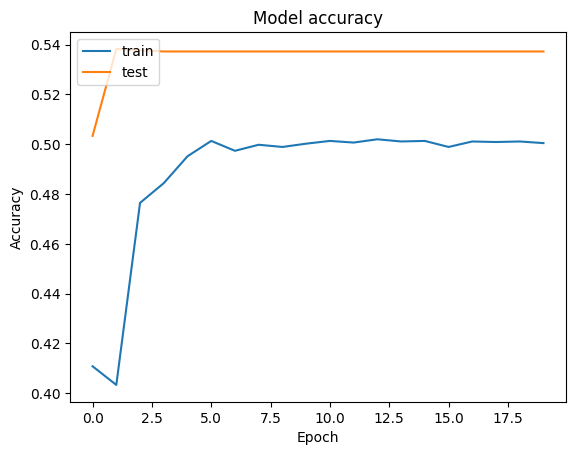

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
ann.evaluate(X_test, y_test_ann)

61/61 [==============================] - 0s 2ms/step - loss: 0.9788 - accuracy: 0.5372


[0.9787870645523071, 0.537236750125885]

### Random Forest Model

In [51]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_rf)))
rf_scores = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (rf_scores.mean(), rf_scores.std() * 2))

Accuracy Score: 0.8998459167950693
Cross-validated Accuracy: 0.90 (+/- 0.02)


In [52]:
rf_scores

array([0.89768977, 0.889989  , 0.9185022 , 0.88325991, 0.89867841])

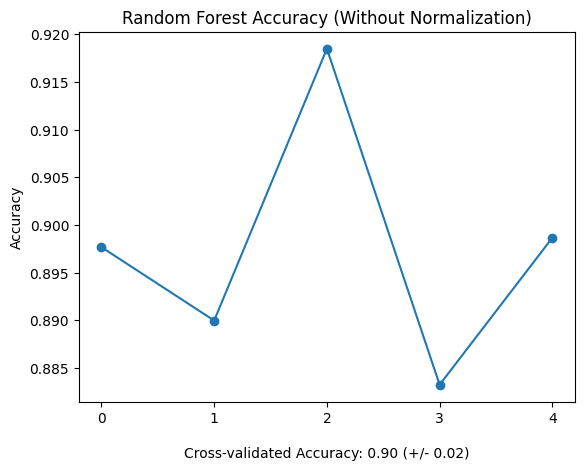

In [53]:
rf_data = np.array(rf_scores)
indices = np.arange(len(rf_data))

plt.plot(indices, rf_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {rf_scores.mean():.2f} (+/- {(rf_scores.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy (Without Normalization)')
plt.show()

### SVC Model

In [54]:
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_svc)))
svc_scores = cross_val_score(svc, X_train, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (svc_scores.mean(), svc_scores.std() * 2))

Accuracy Score: 0.610683102208526
Cross-validated Accuracy: 0.58 (+/- 0.01)


In [55]:
svc_scores

array([0.57755776, 0.59185919, 0.5715859 , 0.57488987, 0.57378855])

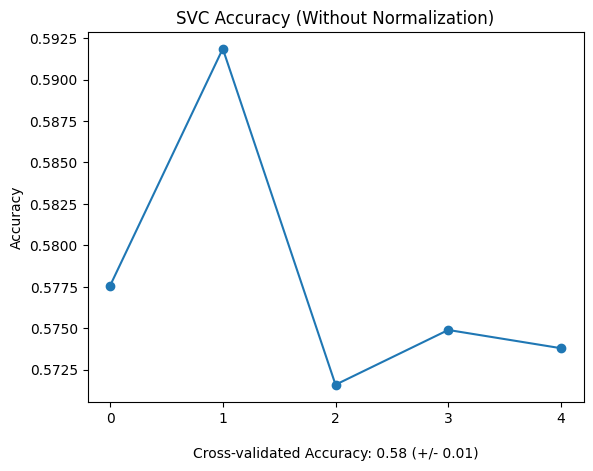

In [56]:
svc_data = np.array(svc_scores)
indices = np.arange(len(svc_data))

plt.plot(indices, svc_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {svc_scores.mean():.2f} (+/- {(svc_scores.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('SVC Accuracy (Without Normalization)')
plt.show()

### XGBoost Model

In [57]:
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_xgb)))
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (xgb_scores.mean(), xgb_scores.std() * 2))

Accuracy Score: 0.9702105803800719
Cross-validated Accuracy: 0.96 (+/- 0.01)


In [58]:
xgb_scores

array([0.96369637, 0.96589659, 0.96585903, 0.95814978, 0.969163  ])

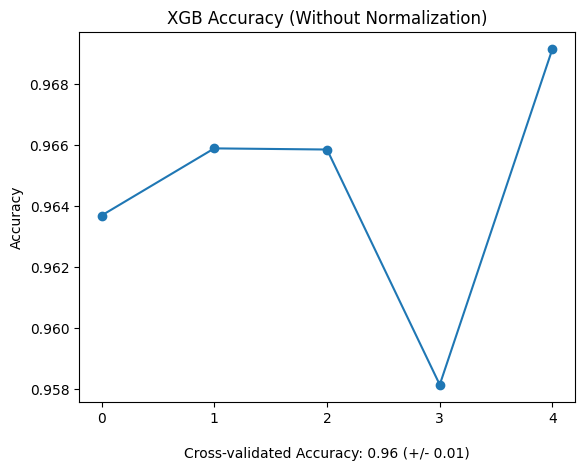

In [59]:
xgb_data = np.array(xgb_scores)
indices = np.arange(len(xgb_data))

plt.plot(indices, xgb_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {xgb_scores.mean():.2f} (+/- {(xgb_scores.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('XGB Accuracy (Without Normalization)')
plt.show()

In [60]:
# in this scenario, XGBoost is the best model
best_model = {
    "Model":["XGBoost"],
    "Scenario":["Without Normalization"],
    "Prediction":[pred_xgb],
    "Accuracy":[xgb_scores.mean()]
}
best_model = pd.DataFrame(best_model)
best_model

,Model,Scenario,Prediction,Accuracy
0,XGBoost,Without Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553


## With Normalization

### Normalization

In [61]:
scaler = StandardScaler()

X_norm = scaler.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns = X.columns)
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y, random_state = 42, shuffle = True, test_size = 0.3)

In [62]:
y_train_ann = tf.keras.utils.to_categorical(y_train, 3)
y_test_ann = tf.keras.utils.to_categorical(y_test, 3)

### ANN Model

In [63]:
input_dim = len(X_train_norm.columns)
ann_norm = Sequential()

ann_norm.add(Dense(512, activation = 'relu', input_shape = (input_dim,)))
ann_norm.add(Dropout(0.6)) # Avoid Overfitting
ann_norm.add(Dense(512, activation = 'relu'))
ann_norm.add(Dropout(0.6)) # Avoid Overfitting
ann_norm.add(Dense(512, activation = 'relu'))
ann_norm.add(Dropout(0.6)) # Avoid Overfitting
ann_norm.add(Dense(3, activation = 'softmax'))

ann_norm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               9728      
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [64]:
checkpoint_path = 'training_model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=3,
                                            factor=0.5,
                                            min_lr = 1e-6,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=1)

In [65]:
ann_norm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
history_norm = ann_norm.fit (X_train_norm, y_train_ann,
                        validation_data = (X_test_norm, y_test_ann), 
                        callbacks = [cp_callback, lr_reduction, early_stoping],
                        batch_size = 64,
                        epochs = 100)

Epoch 1/100
58/71 [=======================>......] - ETA: 0s - loss: 0.7914 - accuracy: 0.6331
Epoch 1: saving model to training_model/cp.ckpt
71/71 [==============================] - 2s 8ms/step - loss: 0.7620 - accuracy: 0.6455 - val_loss: 0.5972 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 2/100
57/71 [=======================>......] - ETA: 0s - loss: 0.6408 - accuracy: 0.7163
Epoch 2: saving model to training_model/cp.ckpt
71/71 [==============================] - 0s 6ms/step - loss: 0.6276 - accuracy: 0.7224 - val_loss: 0.5424 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 3/100
70/71 [============================>.] - ETA: 0s - loss: 0.6040 - accuracy: 0.7388
Epoch 3: saving model to training_model/cp.ckpt
71/71 [==============================] - 0s 6ms/step - loss: 0.6039 - accuracy: 0.7384 - val_loss: 0.5217 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 4/100
58/71 [=======================>......] - ETA: 0s - loss: 0.5801 - accuracy: 0.7352
Epoch 4: saving model to training_model/cp.ckpt
71

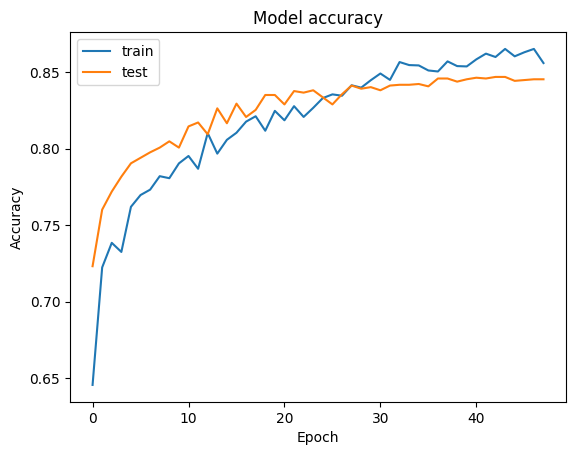

In [67]:
plt.plot(history_norm.history['accuracy'])
plt.plot(history_norm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
ann_norm.evaluate(X_test_norm, y_test_ann)

61/61 [==============================] - 0s 3ms/step - loss: 0.3456 - accuracy: 0.8469


[0.3455864489078522, 0.8469440340995789]

### Random Forest Model

In [69]:
rf.fit(X_train_norm, y_train)
pred_rf_norm = rf.predict(X_test_norm)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_rf_norm)))
rf_scores_norm = cross_val_score(rf, X_train_norm, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (rf_scores_norm.mean(), rf_scores_norm.std() * 2))

Accuracy Score: 0.8952234206471494
Cross-validated Accuracy: 0.90 (+/- 0.02)


In [70]:
rf_scores_norm

array([0.90429043, 0.89218922, 0.90969163, 0.88215859, 0.90638767])

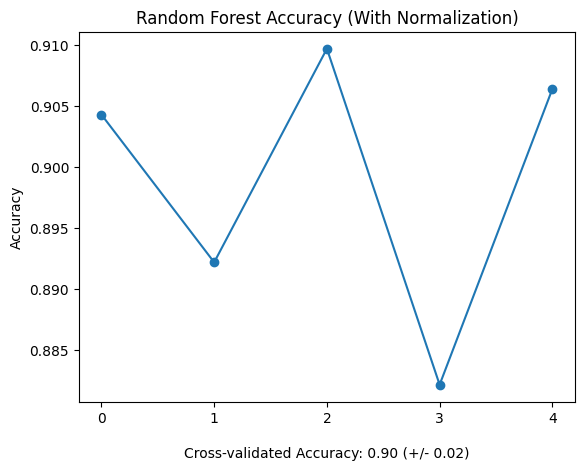

In [71]:
rf_norm_data = np.array(rf_scores_norm)
indices = np.arange(len(rf_norm_data))

plt.plot(indices, rf_norm_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {rf_scores_norm.mean():.2f} (+/- {(rf_scores_norm.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy (With Normalization)')
plt.show()

### SVC Model

In [72]:
svc.fit(X_train_norm, y_train)
pred_svc_norm = svc.predict(X_test_norm)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_svc_norm)))
svc_scores_norm = cross_val_score(svc, X_train_norm, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (svc_scores_norm.mean(), svc_scores_norm.std() * 2))

Accuracy Score: 0.7986646122239343
Cross-validated Accuracy: 0.80 (+/- 0.03)


In [73]:
svc_scores_norm

array([0.80748075, 0.79427943, 0.80837004, 0.76651982, 0.80066079])

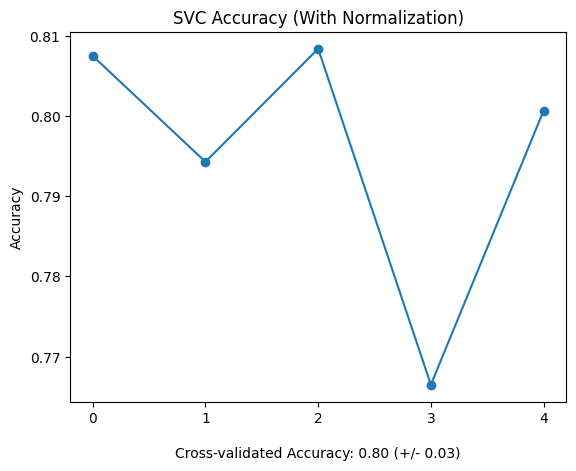

In [74]:
svc_norm_data = np.array(svc_scores_norm)
indices = np.arange(len(svc_norm_data))

plt.plot(indices, svc_norm_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {svc_scores_norm.mean():.2f} (+/- {(svc_scores_norm.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('SVC Accuracy (With Normalization)')
plt.show()

### XGBoost Model

In [75]:
xgb.fit(X_train_norm, y_train)
pred_xgb_norm = xgb.predict(X_test_norm)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_xgb_norm)))
xgb_scores_norm = cross_val_score(xgb, X_train_norm, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (xgb_scores_norm.mean(), xgb_scores_norm.std() * 2))

Accuracy Score: 0.9702105803800719
Cross-validated Accuracy: 0.96 (+/- 0.01)


In [76]:
xgb_scores_norm

array([0.96369637, 0.96589659, 0.96585903, 0.95814978, 0.969163  ])

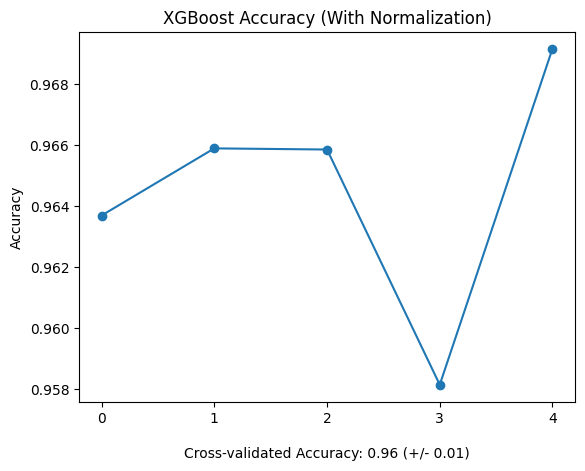

In [77]:
xgb_norm_data = np.array(xgb_scores_norm)
indices = np.arange(len(xgb_norm_data))

plt.plot(indices, xgb_norm_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {xgb_scores_norm.mean():.2f} (+/- {(xgb_scores_norm.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy (With Normalization)')
plt.show()

In [78]:
# in this scenario, XGBoost is still the best model
best_model.loc[len(best_model.index)] = ['XGBoost', "With Normalization", pred_xgb_norm, xgb_scores_norm.mean()]
best_model

,Model,Scenario,Prediction,Accuracy
0,XGBoost,Without Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
1,XGBoost,With Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553


## Results Summary

### Without Normalization

- ANN : 49 - 50%; Val_Accuracy = 53%

- RandomForest : 90% (+/- 2%) -> 88 - 92%

- SVM : 59% (+/- 2%) -> 57 - 61%

- XGBoost : 97% (+/- 1%) -> 96 - 98%


### With Normalization

- ANN : 85 - 86%; Val_Accuracy = 84 - 85%

- RandomForest : 90% (+/- 2%) -> 88 - 92%

- SVM : 79% (+/- 5%) -> 74 - 84%

- XGBoost : 97% (+/- 1%) -> 96 - 98%


### Conclusion

Using Normalization results in better accuracy for 2 models (ANN and SVM) and has no effect to the other 2 models (RandomForest and XGBoost). Therefore, it is better to use Normalization.

# Non Selection Features vs Selection Features

## Features Selection

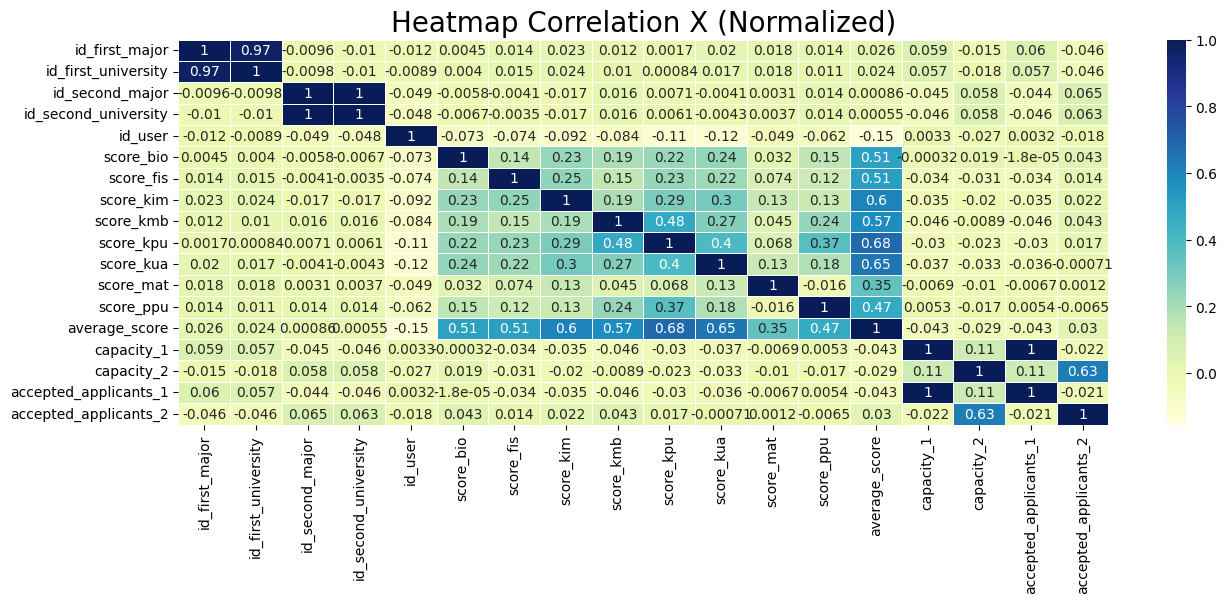

In [79]:
plt.figure(figsize=(15, 5)) 
dataplot = sns.heatmap(X_norm.corr(), cmap="YlGnBu", annot=True, cbar = True, linewidths=.5) 
plt.title('Heatmap Correlation X (Normalized)', fontsize = 20)
plt.show() 

In the correlation heatmap above, we can select features by using representatives of relevant features such as:


[Representative Feature] => [Drop Features]
- id_first_major => id_first_university
- id_second_major => id_second_university
- average_score => score_bio, score_fis, score_kim, score_kmb, score_kpu, score_kua, score_mat, score_ppu
- capacity_1 => accepted_applicants_1
- capacity_2 => accepted_applicants_2

Extra : We need to drop `id_user` because it's too unique

In [80]:
X_select = X_norm.drop(columns=['id_first_university', 'id_second_university',
                                'score_bio', 'score_fis', 'score_kim', 'score_kmb',
                                'score_kpu', 'score_kua', 'score_mat', 'score_ppu',
                                'accepted_applicants_1', 'accepted_applicants_2',
                                'id_user'])
X_select

,id_first_major,id_second_major,average_score,capacity_1,capacity_2
0,0.122271,-0.173617,4.028592,-0.139727,-0.789211
1,0.122145,3.997636,3.450991,0.144238,0.725780
2,0.122652,0.071915,3.388417,0.087445,-0.088731
3,0.122652,0.235420,3.347504,0.087445,-0.789211
4,0.122145,-4.181591,3.205510,0.144238,-0.267924
...,...,...,...,...,...
6484,7.551201,0.088462,-2.902618,-0.565674,-0.593728
6485,-0.325304,0.087974,-2.919465,-0.934829,-0.137602
6486,-0.384315,0.088367,-2.919465,-0.565674,3.772050
6487,-0.384581,0.088537,-2.936311,-0.210718,-0.267924


In [81]:
X_train_select, X_test_select, y_train, y_test = train_test_split(X_select, y, random_state = 42, shuffle = True, test_size = 0.3)

In [82]:
y_train_ann = tf.keras.utils.to_categorical(y_train, 3)
y_test_ann = tf.keras.utils.to_categorical(y_test, 3)

## With Features Selection

### ANN Model

In [83]:
input_dim = len(X_train_select.columns)
ann_select = Sequential()

ann_select.add(Dense(512, activation = 'relu', input_shape = (input_dim,)))
ann_select.add(Dropout(0.2)) 
ann_select.add(Dense(512, activation = 'relu'))
ann_select.add(Dropout(0.2))
ann_select.add(Dense(512, activation = 'relu'))
ann_select.add(Dropout(0.2))
ann_select.add(Dense(3, activation = 'softmax'))

ann_select.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               3072      
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                

In [84]:
checkpoint_path = 'training_model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=3,
                                            factor=0.5,
                                            min_lr = 1e-6,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=1)

In [85]:
ann_select.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [86]:
history_select = ann_select.fit (X_train_select, y_train_ann,
                                 validation_data = (X_test_select, y_test_ann), 
                                 callbacks = [cp_callback, lr_reduction, early_stoping],
                                 batch_size = 64,
                                 epochs = 100)

Epoch 1/100
58/71 [=======================>......] - ETA: 0s - loss: 0.6559 - accuracy: 0.7047
Epoch 1: saving model to training_model/cp.ckpt
71/71 [==============================] - 2s 8ms/step - loss: 0.6539 - accuracy: 0.7089 - val_loss: 0.5635 - val_accuracy: 0.7329 - lr: 0.0010
Epoch 2/100
57/71 [=======================>......] - ETA: 0s - loss: 0.5573 - accuracy: 0.7497
Epoch 2: saving model to training_model/cp.ckpt
71/71 [==============================] - 0s 6ms/step - loss: 0.5540 - accuracy: 0.7517 - val_loss: 0.5087 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 3/100
59/71 [=======================>......] - ETA: 0s - loss: 0.5081 - accuracy: 0.7720
Epoch 3: saving model to training_model/cp.ckpt
71/71 [==============================] - 0s 6ms/step - loss: 0.5098 - accuracy: 0.7699 - val_loss: 0.4693 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.7897
Epoch 4: saving model to training_model/cp.ckpt
71

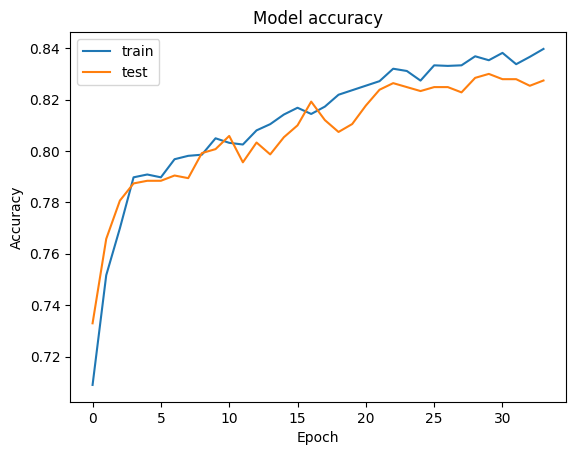

In [87]:
plt.plot(history_select.history['accuracy'])
plt.plot(history_select.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
ann_select.evaluate(X_test_select, y_test_ann)

61/61 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8285


[0.367744505405426, 0.8284540176391602]

### Random Forest Model

In [89]:
rf.fit(X_train_select, y_train)
pred_rf_select = rf.predict(X_test_select)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_rf_select)))
rf_scores_select = cross_val_score(rf, X_train_select, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (rf_scores_select.mean(), rf_scores_select.std() * 2))

Accuracy Score: 0.9558294812532101
Cross-validated Accuracy: 0.94 (+/- 0.01)


In [90]:
rf_scores_select

array([0.94059406, 0.93839384, 0.95264317, 0.93281938, 0.94713656])

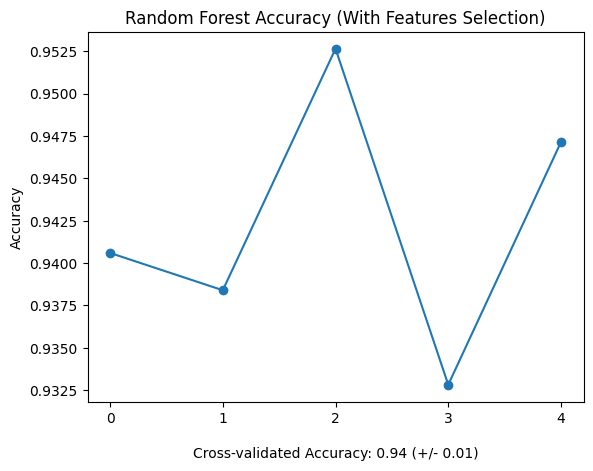

In [91]:
rf_select_data = np.array(rf_scores_select)
indices = np.arange(len(rf_select_data))

plt.plot(indices, rf_select_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {rf_scores_select.mean():.2f} (+/- {(rf_scores_select.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy (With Features Selection)')
plt.show()

### SVC Model

In [92]:
svc.fit(X_train_select, y_train)
pred_svc_select = svc.predict(X_test_select)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_svc_select)))
svc_scores_select = cross_val_score(svc, X_train_select, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (svc_scores_select.mean(), svc_scores_select.std() * 2))

Accuracy Score: 0.7519260400616333
Cross-validated Accuracy: 0.75 (+/- 0.04)


In [93]:
svc_scores_select

array([0.77447745, 0.75357536, 0.75440529, 0.71475771, 0.75991189])

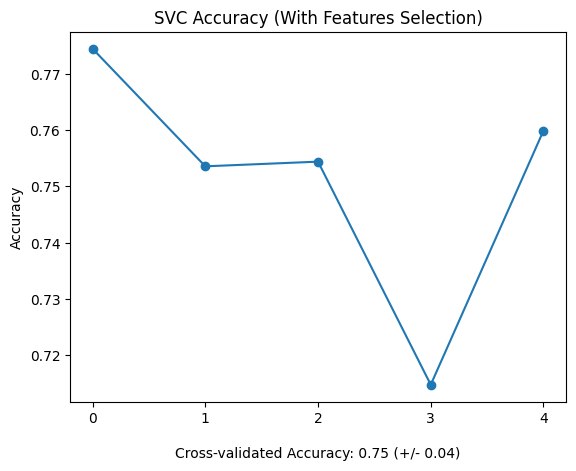

In [94]:
svc_select_data = np.array(svc_scores_select)
indices = np.arange(len(svc_select_data))

plt.plot(indices, svc_select_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {svc_scores_select.mean():.2f} (+/- {(svc_scores_select.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('SVC Accuracy (With Features Selection)')
plt.show()

### XGBoost Model

In [95]:
xgb.fit(X_train_select, y_train)
pred_xgb_select = xgb.predict(X_test_select)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_xgb_select)))
xgb_scores_select = cross_val_score(xgb, X_train_select, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (xgb_scores_select.mean(), xgb_scores_select.std() * 2))

Accuracy Score: 0.9856189008731382
Cross-validated Accuracy: 0.98 (+/- 0.01)


In [96]:
xgb_scores_select

array([0.98019802, 0.97249725, 0.97797357, 0.9746696 , 0.97687225])

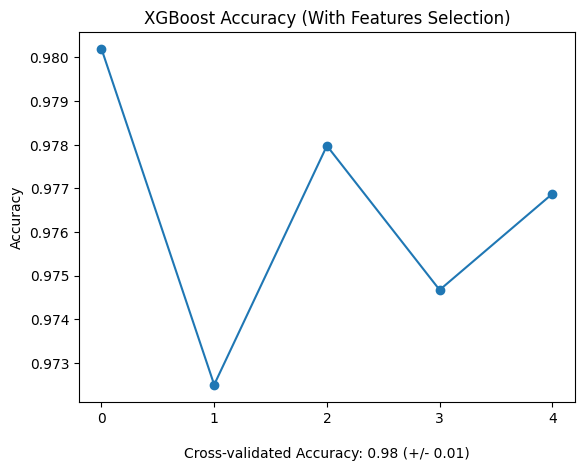

In [97]:
xgb_select_data = np.array(xgb_scores_select)
indices = np.arange(len(xgb_select_data))

plt.plot(indices, xgb_select_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {xgb_scores_select.mean():.2f} (+/- {(xgb_scores_select.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy (With Features Selection)')
plt.show()

In [98]:
# in this scenario, XGBoost is still the best model
best_model.loc[len(best_model.index)] = ['XGBoost', "Feature Selection + Normalization", pred_xgb_select, xgb_scores_select.mean()]
best_model

,Model,Scenario,Prediction,Accuracy
0,XGBoost,Without Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
1,XGBoost,With Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
2,XGBoost,Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.976442


## Results Summary

### Without Features Selection

- ANN : 85 - 86%; Val_Accuracy = 84 - 85%

- RandomForest : 90% (+/- 2%) -> 88 - 92%

- SVM : 79% (+/- 5%) -> 74 - 84%

- XGBoost : 97% (+/- 1%) -> 96 - 98%


### With Features Selection

- ANN : 84 - 85%; Val_Accuracy = 83 - 84%

- RandomForest : 94% (+/- 1%) -> 93 - 95%

- SVM : 75% (+/- 3%) -> 72 - 78%

- XGBoost : 97% (+/- 0%) -> 97%


### Conclusion

Using Features Selection results in better for 1 model (RandomForest) and more stable accuracy for 2 models (SVM and XGBoost), but worse accuracy for ANN. Therefore, it is better to use Features Selection, as the best model which are going to be used are XGBoost because the results is quite the same with less computing cost.

# Hyperparameter Tuning for Best Model

## Hyperparameter Tuning

### GridSearch

In [99]:
def hyperParameterTuning(X_train_select, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
        'max_depth': [3, 5, 6, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'n_estimators' : [100, 200, 500],
    }

    xgb = XGBClassifier(random_state = 42)

    grid_search = GridSearchCV(estimator = xgb,
                                 param_grid = param_tuning,                        
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = 1)

    grid_search.fit(X_train_select, y_train)

    return grid_search.best_params_

best_params = hyperParameterTuning(X_train_select, y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [100]:
best_params

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 1}

### RandomizedSearch

In [101]:
def randHyperParameterTuning(X_train_select, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
        'max_depth': [3, 5, 6, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'n_estimators' : [100, 200, 500],
    }

    xgb = XGBClassifier(random_state = 42)

    random_search = RandomizedSearchCV(estimator = xgb,
                                 param_distributions = param_tuning,                        
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = 1)

    random_search.fit(X_train_select, y_train)
    return random_search.best_params_

rand_best_params = randHyperParameterTuning(X_train_select, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [102]:
rand_best_params

{'subsample': 1,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.5,
 'colsample_bytree': 1}

## XGBoost Model

### GridSearch Parameters

In [103]:
xgb = XGBClassifier(**best_params)

xgb.fit(X_train_select, y_train)
pred_xgb_hyper = xgb.predict(X_test_select)

print('Accuracy Score: ' + str(accuracy_score(y_test, pred_xgb_hyper)))
xgb_scores_hyper = cross_val_score(xgb, X_train_select, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (xgb_scores_hyper.mean(), xgb_scores_hyper.std() * 2))

Accuracy Score: 0.9820236260914227
Cross-validated Accuracy: 0.98 (+/- 0.01)


In [104]:
xgb_scores_hyper

array([0.97469747, 0.97579758, 0.98017621, 0.97907489, 0.98237885])

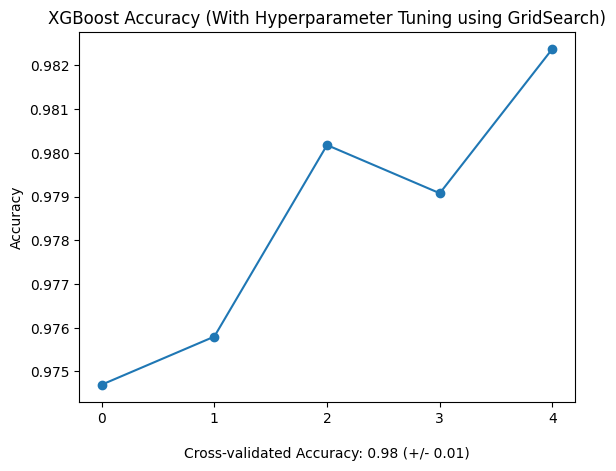

In [105]:
xgb_hyper_data = np.array(xgb_scores_hyper)
indices = np.arange(len(xgb_hyper_data))

plt.plot(indices, xgb_hyper_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {xgb_scores_hyper.mean():.2f} (+/- {(xgb_scores_hyper.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy (With Hyperparameter Tuning using GridSearch)')
plt.show()

In [106]:
best_model.loc[len(best_model.index)] = ['XGBoost', "(Grid Search) Feature Selection + Normalization", pred_xgb_hyper, xgb_scores_hyper.mean()]
best_model

,Model,Scenario,Prediction,Accuracy
0,XGBoost,Without Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
1,XGBoost,With Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
2,XGBoost,Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.976442
3,XGBoost,(Grid Search) Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.978425


### RandomizedSearch Parameters

In [107]:
rand_xgb = XGBClassifier(**rand_best_params)

rand_xgb.fit(X_train_select, y_train)
rand_pred_xgb_hyper = rand_xgb.predict(X_test_select)

print('Accuracy Score: ' + str(accuracy_score(y_test, rand_pred_xgb_hyper)))
rand_xgb_scores_hyper = cross_val_score(rand_xgb, X_train_select, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (rand_xgb_scores_hyper.mean(), rand_xgb_scores_hyper.std() * 2))

Accuracy Score: 0.9825372367745249
Cross-validated Accuracy: 0.97 (+/- 0.01)


In [108]:
rand_xgb_scores_hyper

array([0.97909791, 0.9669967 , 0.97907489, 0.97246696, 0.97577093])

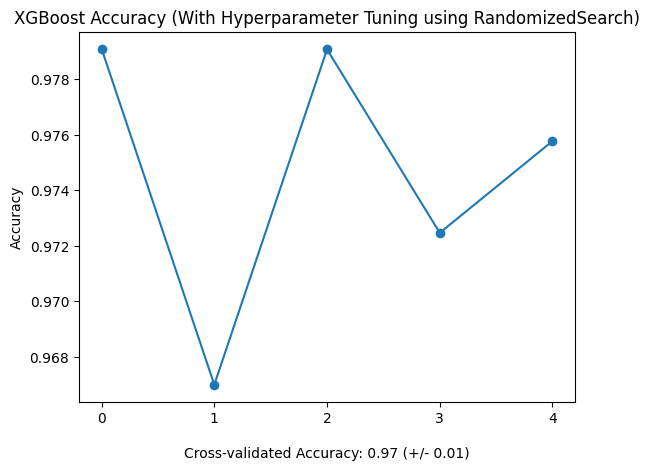

In [109]:
xgb_rand_hyper_data = np.array(rand_xgb_scores_hyper)
indices = np.arange(len(xgb_rand_hyper_data))

plt.plot(indices, xgb_rand_hyper_data, marker='o', linestyle='-')
plt.xticks(np.arange(min(indices), max(indices) + 1, 1))
plt.xlabel(f"\nCross-validated Accuracy: {rand_xgb_scores_hyper.mean():.2f} (+/- {(rand_xgb_scores_hyper.std()* 2):.2f})")
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy (With Hyperparameter Tuning using RandomizedSearch)')
plt.show()

In [110]:
best_model.loc[len(best_model.index)] = ['XGBoost', "(Randomized Search) Feature Selection + Normalization", rand_pred_xgb_hyper, rand_xgb_scores_hyper.mean()] 
best_model

,Model,Scenario,Prediction,Accuracy
0,XGBoost,Without Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
1,XGBoost,With Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
2,XGBoost,Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.976442
3,XGBoost,(Grid Search) Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.978425
4,XGBoost,(Randomized Search) Feature Selection + Normal...,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.974681


In [111]:
# Sort best scenario
sort_best_model = best_model.sort_values('Accuracy', ascending = False)
sort_best_model.reset_index(drop = True, inplace = True)
sort_best_model

,Model,Scenario,Prediction,Accuracy
0,XGBoost,(Grid Search) Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.978425
1,XGBoost,Feature Selection + Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.976442
2,XGBoost,(Randomized Search) Feature Selection + Normal...,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.974681
3,XGBoost,Without Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553
4,XGBoost,With Normalization,"[1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, ...",0.964553


## Results Summary

### Without Hyperparameter Tuning

98% (+/- 1%) -> 97% - 99%

### With Hyperparameter Tuning

- GridSearch : 98% (+/- 1%) -> 97 - 99%

- RandomizedSearch : 97% (+/- 1%) -> 96 - 98%

### Conclusion

Using Hyperparameter Tuning with parameters from GridSearch results in better accuracy for XGBoost Model than using parameters from RandomizedSearch or without any Hyperparameter Tuning. Therefore, it is better to use Hyperparameter Tuning with GridSearch.

# Model Evaluation

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       277
           1       0.99      0.99      0.99      1046
           2       0.97      0.98      0.98       624

    accuracy                           0.98      1947
   macro avg       0.98      0.98      0.98      1947
weighted avg       0.98      0.98      0.98      1947



Text(0.5, 1.0, 'Confusion Matrix')

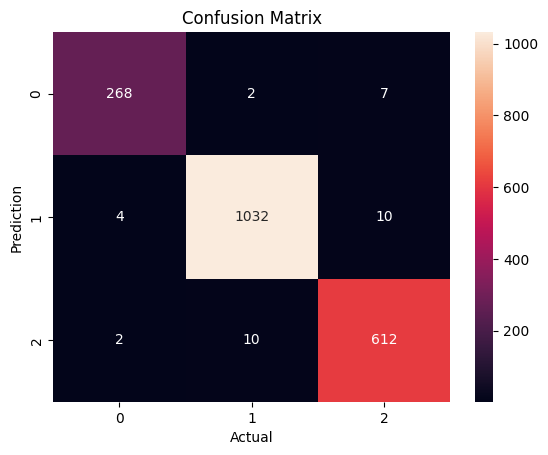

In [112]:
print(classification_report(y_test, sort_best_model.loc[0, 'Prediction']))
cf_matrix = confusion_matrix(y_test, sort_best_model.loc[0, 'Prediction'])
sns.heatmap(cf_matrix, annot=True, fmt='')
plt.xlabel("Actual")
plt.ylabel('Prediction')
plt.title('Confusion Matrix')

# Final Conclusion

The final best model chosen is XGBoost Model with Normalization, Features Selection, and Hyperparameter Tuning using GridSearch.

Final accuracy : 98% (+/- 1%) -> 97 - 99%.

# Thank You

> Author
> - Andika Rahman Teja
> - Kevin Nathanael Halim